# Mixture Density Network

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer, Input, Dense, BatchNormalization
from tensorflow.keras.models import Model
import math
%matplotlib inline

In [169]:
NSAMPLE = 3000
uniforms = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
y_data = np.copy(uniforms)
normals = np.float32(np.random.normal(size=(NSAMPLE,1)))
x_data = np.float32(np.sin(y_data*0.7)*4.0 + y_data*0.5)
for i in range(NSAMPLE): # ADD NOISE 
    y_data[i] = uniforms[i] + 0.01*(x_data[i]+30)*normals[i]

Text(0,0.5,'Output')

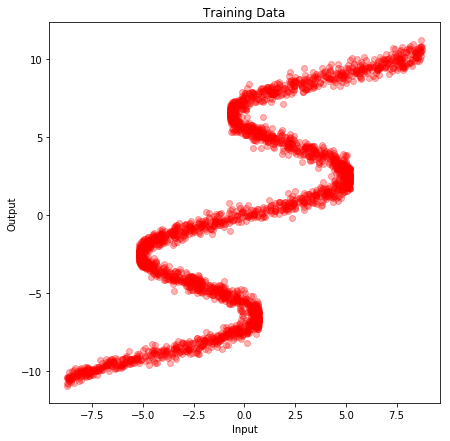

In [170]:
plt.figure(figsize=(7, 7))
plt.plot(x_data, y_data, 'ro', alpha=0.3)
plt.title("Training Data")
plt.xlabel("Input")
plt.ylabel("Output")

In [171]:
data1 = np.arange(40).reshape(4, 10)
data2 = np.arange(40).reshape(4, 10)
data3 = np.arange(40).reshape(4, 10)
np.hstack([data1, data2, data3]).shape

(4, 30)

In [219]:
pi = math.pi
n_gaussians = 10

# Output from normal distribution on single input x

def split3(inputs, size):
    pi, mu, sigma = inputs[:, :size],\
                    inputs[:, size:size*2],\
                    inputs[:, size*2:]
    return pi, mu, sigma
    
def gaussian_fn(x, mu, sigma):
    result = (x - mu) / sigma
    result = -K.square(result) / 2.
    result = K.exp(result) / math.sqrt(2*pi)*sigma
    return result

def gmm_loss(y_true, y_distribution_params):
    pi, mu, sigma = split3(y_distribution_params, n_gaussians)
    probs = gaussian_fn(y_true, mu, sigma)
    weighted_sum = K.sum(pi*probs, axis=1, keepdims=True)
    return K.mean(-K.log(weighted_sum))

class MixturesLayer(Layer):
    def __init__(self, output_dim, n_g=10, **kwargs):
        self.n_g = n_g
        self.output_dim = output_dim
        super(MixturesLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        last_shape = int(input_shape[1]) # This should be fixed, really
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(last_shape, self.output_dim),
                                      initializer='he_normal',
                                      trainable=True)
        self.bias = self.add_weight(name='bias',
                                    shape=(1, self.output_dim),
                                    initializer='zeros',
                                    trainable=True)
        super(MixturesLayer, self).build(input_shape)
            
    
    def call(self, x):
        ff = K.dot(x, self.kernel) + self.bias
        pi, mu, sigma = split3(K.dot(x, self.kernel)+self.bias, self.n_g)
        pi = K.softmax(pi)
        
        sigma = 3*K.sigmoid(sigma)
        print(pi.shape, mu.shape, sigma.shape)
        stacked = K.reshape(K.concatenate([pi, mu, sigma]), (-1, self.n_g*3))
        print(stacked.shape)
        return stacked



def train_mdn():
    epochs = 10
    learning_rate = 0.1
    input_dim = 1
    batch_size = 256
    
    inputs = Input(shape=(input_dim,), name="input")

    h1 = Dense(10, activation='tanh', name='h1')(inputs)
    h2 = Dense(10, activation='tanh', name='h2')(h1)
    out = MixturesLayer(n_gaussians*3, name='out')(h2)
    
    
    x_sample = np.float32(np.arange(-10.5, 10.5, 0.3)).reshape(-1, 1)
    
    model = Model(inputs, out, name='mdn')
    model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate), 
                  loss=gmm_loss,
                  metrics=['accuracy'])
    model.summary()
    
    hist = model.fit(x_data, y_data,
                      epochs=epochs,
                      batch_size=batch_size,
                      shuffle=True,
                      verbose=1)
    

    results = model.predict(x_sample)
    pi, mu, sigma = split3(results, n_gaussians)
    print(np.mean(pi), np.mean(mu), np.mean(sigma))
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,8))
    ax1.plot(x_sample, pi)
    ax1.set_title('$p(c = i | x)$')
    ax2.plot(x_sample, sigma)
    ax2.set_title('$\sigma$')
    ax3.plot(x_sample, mu)
    ax3.set_title('$\mu$')
    plt.xlim([-11,11])
    plt.show()
    
    plt.figure(figsize=(8, 8), facecolor='white')
    for pi_k, mu_k, sigma_k in zip(pi.T, mu.T, sigma.T):
        print(pi_k.shape, mu_k.shape, sigma_k.shape)
        plt.plot(x_sample, mu_k)
        plt.fill_between(x_sample.reshape((-1,)), mu_k-sigma_k*0.5, mu_k+sigma_k*0.5, alpha=float(pi_k))
    plt.xlim([-10,10])
    plt.ylim([-10,10])
    plt.show()

(?, 10) (?, 10) (?, 10)
(?, 30)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1)                 0         
_________________________________________________________________
h1 (Dense)                   (None, 10)                20        
_________________________________________________________________
h2 (Dense)                   (None, 10)                110       
_________________________________________________________________
out (MixturesLayer)          (None, 30)                330       
Total params: 460
Trainable params: 460
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3000/3000 [==============================] - 6s 2ms/step - loss: 1.9558 - acc: 0.0000e+00
Epoch 2/10
3000/3000 [==============================] - 0s 18us/step - loss: 0.6574 - acc: 0.0000e+00
Epoch 3/10
3000/3000 [===================

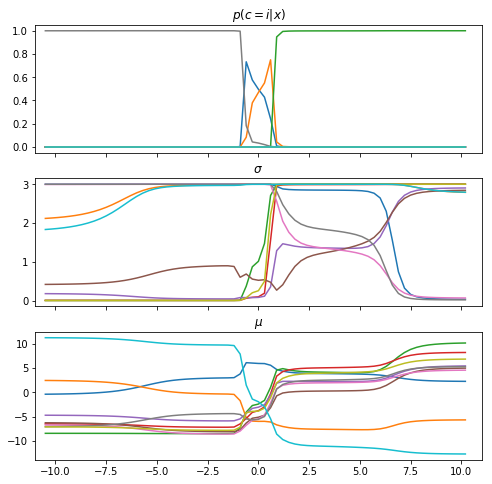

(70,) (70,) (70,)


TypeError: only size-1 arrays can be converted to Python scalars

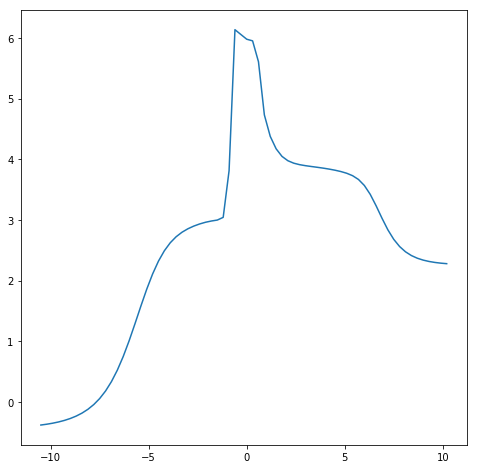

In [220]:
train_mdn()